# Recurrent Neural Networks

In [314]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [315]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [316]:
from pandas.tseries.offsets import MonthEnd

In [317]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


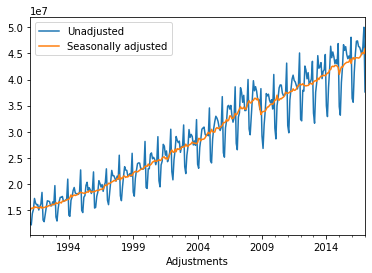

In [318]:
df.plot()

In [319]:
split_date = pd.Timestamp('01-01-2011')

In [320]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

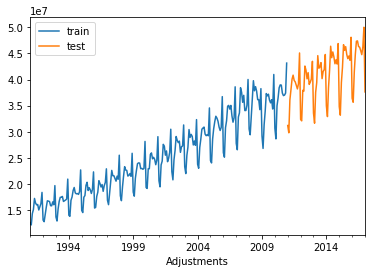

In [321]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [322]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [323]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [324]:
X_train = train_sc[:-1]
y_train = train_sc[1:] # shift by 1

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Fully connected predictor

In [325]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [326]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [327]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [328]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
239/239 [==============================] - 1s 2ms/step - loss: 0.1102
Epoch 2/200
239/239 [==============================] - 0s 662us/step - loss: 0.0438
Epoch 3/200
239/239 [==============================] - 0s 744us/step - loss: 0.0280
Epoch 4/200
239/239 [==============================] - 0s 615us/step - loss: 0.0245
Epoch 5/200
239/239 [==============================] - 0s 571us/step - loss: 0.0226
Epoch 6/200
239/239 [==============================] - 0s 589us/step - loss: 0.0210
Epoch 7/200
239/239 [==============================] - 0s 602us/step - loss: 0.0192
Epoch 8/200
239/239 [==============================] - 0s 577us/step - loss: 0.0176
Epoch 9/200
239/239 [==============================] - 0s 598us/step - loss: 0.0162
Epoch 10/200
239/239 [==============================] - 0s 708us/step - loss: 0.0149
Epoch 11/200
239/239 [==============================] - 0s 768us/step - loss: 0.0139
Epoch 12/200
239/239 [==============================] - 0s 713us/step - loss

In [329]:
y_pred = model.predict(X_test)

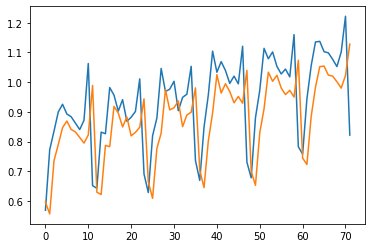

In [330]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [331]:
from keras.layers import LSTM

In [332]:
X_train.shape

(239, 1)

In [333]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [334]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [335]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [336]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 2s 8ms/step - loss: 0.1633
Epoch 2/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0493
Epoch 3/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 4/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0307
Epoch 5/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0246
Epoch 6/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0197
Epoch 7/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0159
Epoch 8/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0138
Epoch 9/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0121
Epoch 10/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0111
Epoch 11/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0109
Epoch 12/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0105
Epoch 13/100


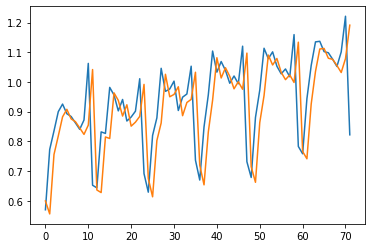

In [337]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows

In [338]:
train_sc.shape

(240, 1)

In [339]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [340]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [341]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [342]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [343]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [344]:
X_train.shape

(228, 12)

In [345]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Fully Connected on Windows

In [346]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [347]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 1s 3ms/step - loss: 0.0815
Epoch 2/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0145
Epoch 3/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 4/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 5/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0081
Epoch 6/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 7/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 8/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 9/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 10/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 11/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 12/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 13/200


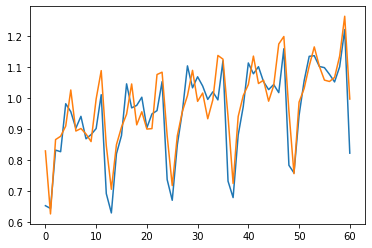

In [348]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

### LSTM on Windows

In [349]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12) # 12 months in one shot
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [350]:
X_train_t.shape

(228, 1, 12)

In [351]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [352]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [353]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 2s 9ms/step - loss: 0.0914
Epoch 2/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0107
Epoch 3/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 4/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 5/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 6/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 7/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 8/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 9/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 10/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 11/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 12/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 13/100


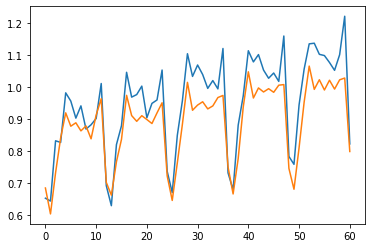

In [354]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

In [355]:
from pandas.tseries.offsets import MonthEnd

df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')

df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


In [356]:
split_date = pd.Timestamp('01-01-2011')

train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

In [357]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [358]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [359]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1) # 1 month at a time
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [360]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.backend as K

K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(12, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


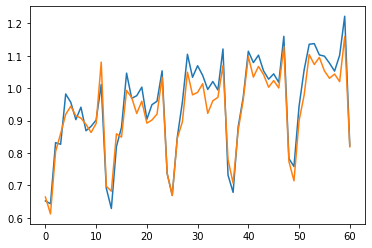

In [361]:
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 2

RNN models can be applied to images too. In general we can apply them to any data where there's a connnection between nearby units. Let's see how we can easily build a model that works with images.

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data
- how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

(feel free to run this exercise on a cloud GPU if it's too slow on your laptop)

In [362]:
# Load the MNIST data, by now you should be able to do it blindfolded :)

from keras.datasets import mnist
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data('/tmp/mnist.npz')

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [363]:
# reshape it so that an image looks like a long sequence of pixels

X_train_t = X_train.reshape((X_train.shape[0],-1))
X_test_t = X_test.reshape((X_test.shape[0],-1))

In [364]:
X_train_t.shape, X_test_t.shape

((60000, 784), (10000, 784))

In [365]:
X_train_t = X_train_t[...,np.newaxis]
X_test_t = X_test_t[...,np.newaxis]

X_train_t.shape

(60000, 784, 1)

In [366]:
# create a recurrent model and train it on the training data
    
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(784,1))) # or X_train.shape[1:]

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                70        
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

model.fit(X_train_t, y_train_cat,
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          shuffle=True,
          verbose=2, 
          callbacks=[early_stop])

model.evaluate(X_test_t, y_test_cat)